## Import modules

In [1]:
import os
# os.chdir("./FoodImageCode") # Run this line if pwd is incorrect 

import io
from copy import deepcopy
from collections import OrderedDict
from itertools import compress

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import csv
import numpy as np
from matplotlib import pyplot as plt
import pillow_avif
from rich import get_console
from rich.progress import track

console = get_console()
plt.style.use("default")
torch.set_grad_enabled(False)

os.path.abspath(os.curdir)

'/home/msoc/ben_aifood/FoodImageCode'

In [2]:
import json

from PIL import Image
import openpyxl as xlsx
import openpyxl.utils as xlutil
from openpyxl.worksheet.worksheet import Worksheet
from openpyxl.styles import Alignment

In [3]:
from cfgparser import CfgParser
from dataset import FoodDataset
from model.ResNet_modified import ModifiedResNet
from metrics import *
from cam import *

## Preliminaries

#### Read Config, load device and get path

In [44]:
# Set device
# device = torch.device(f"cuda:{cfg['GPU_ID']}")
device = torch.device(f"cuda")

# Read config file
cfgparser = CfgParser(config_path="./cfg/Setting.yml")
cfg = cfgparser.cfg_dict

# Read class id and class name
class_id: "dict[str, int]" = {}
class_name: "list[str]" = [None] * cfg["MODEL"]["CATEGORY_NUM"]
with open("../Database/class.txt", "r") as file :
    lines = file.readlines()
for line in lines :
    id, cls = line.split()
    class_id[cls] = int(id)
    class_name[int(id)] = cls

# Read class names
with open("../Database/class chinese.txt", "r", encoding="UTF-8") as file :
    lines = file.readlines()
class_en_ch = [i.split() for i in lines]


In [43]:
# Load model
def load_model(cp_path: str) :
    cp = torch.load(cp_path, map_location=device)
    model = ModifiedResNet(3, 64, cfg["MODEL"]["CATEGORY_NUM"])
    model.load_state_dict(cp["model"])
    model.to(device)
    model.eval()
    return model

# checkpoint1 = "/home/msoc/ben_aifood/FoodImageCode/Results/checkpoints/5_17_single_alpha_25/5_17_ModifiedResNet50_93_epoch_29.pth.tar"
# checkpoint1 = "6_5_ModifiedResNet50_93_epoch_25_original.pth.tar"
# checkpoint2 = "/home/msoc/ben/FoodImageCode/Results/checkpoints/4_2_new_focal1/4_2_ModifiedResNet50_93_epoch_29.pth.tar"
# checkpoint3 = "/home/msoc/ben_aifood/FoodImageCode/Results/checkpoints/7_31_aisingle_multi_8_1_ModifiedResNet50_93_epoch_13.pth.tar"
checkpoint3 = "/home/msoc/ben_aifood/FoodImageCode/Results/checkpoints/7_31_aisingle_multi_8_1_ModifiedResNet50_93_epoch_13.pth.tar"
# checkpoint4 = "/home/msoc/ben_aifood/FoodImageCode/Results/checkpoints/7_24_aisingle/7_25_ModifiedResNet50_93_epoch_14.pth.tar"
# checkpoint5 = "/home/msoc/ben_aifood/FoodImageCode/Results/checkpoints/3_21_focal_adam/3_21_ModifiedResNet50_93_epoch_29.pth.tar"

# model1 = load_model(checkpoint1)
# model2 = load_model(checkpoint2)
model1 = load_model(checkpoint3)
# model1 = load_model(checkpoint4)
# model1 = load_model(checkpoint5)
console.print(model1)

ModifiedResNet(
  (conv1): Conv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2dSame(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (conv2): Conv2dSame(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (conv3): Conv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): Bottleneck(
      (conv1): Conv2dSame(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (conv2): Conv2dSame(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (conv3): Conv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (downsample): Sequential()
      (relu): ReLU()
    )
    (2): Bottleneck(
      (conv1): Conv2dSame(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (conv2): Conv2dSame(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (conv3): Conv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (downsample): Sequential()
      (relu): ReLU()
    )
  )
  (layer2): Sequential(
    (0): Bottleneck(
      (conv1): Conv2dSame(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (conv2): Conv2dSame(128, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (conv3): Conv2dSame(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2dSame(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): Bottleneck(
      (conv1): Conv2dSame(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (conv2): Conv2dSame(128, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (conv3): Conv2dSame(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (downsample): Sequential()
      (relu): ReLU()
    )
    (2): Bottleneck(
      (conv1): Conv2dSame(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (conv2): Conv2dSame(128, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(12

In [45]:
# Define path

# Read path from yaml file
root_path      = cfg["ROOT"]
database_path  = cfg["DATA_BASE_DIR"]
all_csv_path   = cfg["ALL_CSV_DIR"]
train_csv_path = cfg["TRAIN_CSV_DIR"]
test_csv_path  = cfg["TEST_CSV_DIR"]
val_csv_path   = "/home/msoc/ben_aifood/FoodImageCode/Results/logs/7_31_aisingle_muli.csv"
console.print(all_csv_path)

foodseg_path     = cfg["FOODSEG_DIR"]
foodseg_csv_path = cfg["FOODSEG_CSV_DIR"]

# Output path
test_result_path = "./test results"
cam_result_path = "./cam results"
os.makedirs(f"{test_result_path}/aisinglefood", exist_ok=True)
os.makedirs(f"{test_result_path}/foodseg", exist_ok=True)
os.makedirs(cam_result_path, exist_ok=True)

/home/msoc/ben_aifood/FoodImageCode/csv/ai_single_food_multi/AllFoodImage.csv

In [17]:
# Transforms
trfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.522, 0.475, 0.408], std=[0.118, 0.115, 0.117])
])


#### Utilities

In [18]:
### CAM ###

# Load image and apply preprocess
# Return PIL Image and image tensor (unsqueezed)
def load_image(img_path: str) -> "tuple[Image.Image, torch.Tensor]" :
    img_original = Image.open(img_path).convert("RGB")
    image = trfs(img_original).to(device)
    images = torch.Tensor.unsqueeze(image, dim=0)
    return img_original, images

# Inference on an image
# Return model prediction, sorted prediction (probability) and positive predictions (probability > 0.5)
@torch.no_grad()
def inference(model: nn.Module, image: torch.Tensor) :
    # Inference image
    out = model(image)
    cam = model.generate_cam(out["feat"], True)
    out = out["pred"]
    logits = torch.sigmoid(out)

    # Sort prediction results with probability
    preds = list((p.item(), l) for p, l in zip(logits[0], class_name))
    sorted_preds = sorted(preds, key=lambda x: x[0], reverse=True)
    # Positive predictions (probability >= 0.5)
    pos_preds = list(filter(lambda x: x[0] >= .5, sorted_preds))
    
    return logits, preds, sorted_preds, pos_preds, cam

# Generate inference results and CAM of the dataset
@torch.no_grad()
def generate_cam(model: nn.Module, img_csv_path: str, result_path: str) :
    # Create folders for CAM results
    for cls_name in class_name :
        os.makedirs(os.path.join(result_path, cls_name), exist_ok=True)
    
    # Read path and labels of each image
    images: "list[tuple[str, torch.Tensor]]" = []
    with open(img_csv_path, "r") as file :
        reader = csv.reader(file)
        for path, *labels in reader :
            labels = [int(i) for i in labels]
            images.append( (os.path.join(root_path, path), torch.Tensor(labels).to(device)) )

    # Iterate through each image
    for img_path, labels in images :
        
        # Load image
        img_pil, img_tensor = load_image(img_path)

        # Inference
        logits, preds, sorted_preds, pos_preds, cam = inference(model, img_tensor)
        cam = cam[0]
        # print(cam.shape)
        if isinstance(cam, torch.Tensor) :
            cam = cam.detach().cpu().numpy()

        # Generate CAM
        # cam = class_activation_map(model, img_tensor)
        figure = merge_image_cam(img_pil, cam, sorted_preds, pos_preds, class_id, show=False)
        
        # Save figure
        basename = os.path.basename(img_path).rsplit('.', maxsplit=1)[0]
        for label_name in compress(class_name, labels) :
            figure.savefig(
                os.path.join(result_path, label_name, f"{basename}.png"),
                pad_inches = 0,
                bbox_inches = "tight"
            )

        plt.close(figure)
        img_pil.close()

### Analysis ###

# Get number/ratio of FP in each category
def get_class_fp(conf_matrix: torch.Tensor) :
    class_fp = []
    class_fp_ratio = []
    class_fp_name = []

    for i, fp in enumerate(conf_matrix) :
        # Sort fp and exclude self class
        sorted_fp: list = sorted(
            [ (name, val) for name, val in zip(class_name, fp) if class_name[i] != name ],
            key=lambda x: x[1],
            reverse=True
        )

        # Find nonzero index
        zero_idx = 0
        for j, val in enumerate(sorted_fp) :
            if val[1] <= 0 :
                zero_idx = j
                break
        
        class_fp.append([item[1] for item in sorted_fp][:zero_idx])
        class_fp_ratio.append([item[1] / sum(fp) for item in sorted_fp][:zero_idx])
        class_fp_name.append([item[0] for item in sorted_fp][:zero_idx])
    
    return class_fp, class_fp_ratio, class_fp_name

# Sort classs accuracy
def sort_class_acc(accuracy: "torch.Tensor|list") :
    class_name_acc = OrderedDict(zip(class_name, accuracy))
    class_name_acc = OrderedDict(sorted(class_name_acc.items(), key=lambda x: x[1], reverse=True))
    return class_name_acc

### Graph ###

# Plot class accuracy
def plot_acc(class_acc: "dict[str, float]", ylabel="Class F1", show=False) :
    # Plot bar chart
    fig = plt.figure(figsize=(15, 8), dpi=300)
    plt.bar(*zip(*class_acc.items()))
    plt.xticks(rotation=45, ha="right", fontsize=5)
    plt.ylabel(ylabel)
    plt.grid(axis="y")
    if show : plt.show()
    return fig

# Convert matplotlib figure to PIL Image
def fig2img(fig) :
    plt.tight_layout()
    buf = io.BytesIO()
    fig.savefig(
        buf,
        pad_inches = 0,
        bbox_inches = "tight"
    )
    buf.seek(0)
    img = Image.open(buf)
    return img

### JSON ###

# Saved result to json file
def save_results(record: dict, path: str) :
    record_copy = deepcopy(record)
    # Convert Tensor to list
    for key, value in record_copy.items() :
        if isinstance(value, torch.Tensor) :
            record_copy[key] = value.tolist()
    with open(path, "w") as file :
        json.dump(record_copy, file, indent=4, ensure_ascii=False)

# Load saved results from json file
def load_results(path: str, to_tensor=False) :
    with open(path, "r") as file :
        record = json.load(file)
    # Convert list to Tensor
    if to_tensor :
        for key, value in record.items() :
            if isinstance(value, list) :
                record[key] = torch.tensor(value)
    return record

### Excel ###

# Get class id list and class name list
def get_class_lists(include_class: "list[str|int]") -> "tuple[list[int], list[str]]" :
    if include_class is None :
        return None, None
    # Class name list
    elif all(isinstance(i, str) for i in include_class) :
        cls_id_list = [class_id[i] for i in include_class]
        return cls_id_list, include_class
    # Class id list
    elif all(isinstance(i, int) for i in include_class) :
        cls_name_list = [class_name[i] for i in include_class]
        return include_class, cls_name_list
    else :
        return None, None

# Write class accuracy (Precision, Recall, F1) to Workbook
# `include_class` specified which classes should be written, can be list of class names or class ids. Default is None (All classes)
def write_class_acc(
    cls_prec: torch.Tensor,
    cls_recall: torch.Tensor,
    cls_f1: torch.Tensor,
    wb: xlsx.Workbook,
    ws_name = "Class Accuracy",
    include_class: "list[str|int]" = None
) :
    
    # Get worksheet
    if ws_name not in wb.sheetnames :
        ws = wb.create_sheet(ws_name)
    else :
        ws = wb[ws_name]

    # Get included classes
    cls_id_list, cls_name_list = get_class_lists(include_class)

    #  Write headers
    headers = ["English", "中文", "Precision", "Recall", "F1"]
    row = 1
    col = 1
    ws.cell(row, col).value = "Categories"
    for i, value in enumerate(headers, start=col) :
       ws.cell(row+1, i).value = value

    # Write class data
    row += 2
    skip = 0
    for i, (en, ch, prec, recall, f1) in enumerate(zip(
        *zip(*class_en_ch),
        cls_prec, cls_recall, cls_f1
        ), start=row
    ) :
        
        if not (cls_name_list is None or en in cls_name_list) :
            skip += 1
            continue
        i -= skip
        
        # Category names
        ws.cell(i, col).value, ws.cell(i, col+1).value = en, ch
        # Precision, Recall, F1
        ws.cell(i, col+2).value = prec.item()
        ws.cell(i, col+3).value = recall.item()
        ws.cell(i, col+4).value = f1.item()
        
        # Style
        ws.cell(i, col+2).number_format = "0.000"
        ws.cell(i, col+3).number_format = "0.000"
        ws.cell(i, col+4).number_format = "0.000"
    col += 6

# Write confusion matrix
def write_conf_matrix(
    conf_matrix: torch.Tensor,
    wb: xlsx.Workbook,
    ws_name = "Confusion Matrix",
    include_class: "list[str|int]" = None
) :
    
    if ws_name not in wb.sheetnames :
        ws = wb.create_sheet(ws_name)
    else :
        ws = wb[ws_name]
    
    # Get included classes
    cls_id_list, cls_name_list = get_class_lists(include_class)
        
    # Write header
    row = 1
    col = 1
    ws.cell(row, col+1).value = "Prediction"
    ws.cell(row+1, col).value = "Label"
    row += 2
    col += 2

    # Write confusion matrix
    skip = 0
    for i, r in enumerate(conf_matrix, start=row) :
        cls_id = i - row
        if not (cls_id_list is None or cls_id in cls_id_list) :
            skip += 1
            continue
        i -= skip

        # Label
        ws.merge_cells(start_row=i, start_column=col-2, end_row=i, end_column=col-1)
        ws.cell(i, col-2).value = class_name[cls_id]

        skip2 = 0
        for j, val in enumerate(r, start=col) :
            cls_id2 = j - col
            if not (cls_id_list is None or cls_id2 in cls_id_list) :
                skip2 += 1
                continue
            j -= skip2

            # Prediction
            ws.merge_cells(start_row=row-2, start_column=j, end_row=row-1, end_column=j)
            ws.cell(row-2, j).value = class_name[cls_id2]
            ws.cell(row-2, j).alignment = Alignment(textRotation=180)
            
            # Value
            ws.cell(i, j).value = val.item()

def write_misclassify_cls(
    class_fp_name: torch.Tensor,
    class_fp: torch.Tensor,
    class_fp_ratio: torch.Tensor,
    wb: xlsx.Workbook,
    ws_name = "FP in class",
    include_class: "list[str|int]" = None
) :
    
    if ws_name not in wb.sheetnames :
        ws = wb.create_sheet(ws_name)
    else :
        ws = wb[ws_name]

    cls_id_list, cls_name_list = get_class_lists(include_class)

    # Write headers
    row = 1
    col = 1
    headers = ["English", "中文", "Total FP", "Class FP"]
    ws.cell(row, col).value = "Categories"
    for i, value in enumerate(headers, start=col) :
        ws.cell(row+1, i).value = value

    # Write class fp
    row += 2
    col += 2
    skip = 0
    for r, (en, ch, names, values, ratios) in enumerate(zip(
        *zip(*class_en_ch),
        class_fp_name, class_fp, class_fp_ratio), start=row
    ) :
        
        if not (cls_name_list is None or en in cls_name_list) :
            skip += 1
            continue
        r -= skip
    
        # Categories
        ws.cell(r, col-2).value = en
        ws.cell(r, col-1).value = ch

        # Total fp
        ws.cell(r, col).value = f"{sum(values)} ({sum(ratios):.3%})"

        # Each fp
        for i, (name, val, rat) in enumerate(zip(names, values, ratios)) :
            # No need to write 0
            if val <= 0 : break

            ws.cell(r, col+1+i).value = f"{name}: {val} ({rat:.3%})"


## Inference on AIFood/SingleFood dataset

In [46]:
# Load dataset

dataloader = FoodDataset(val_csv_path, transform=trfs, root=root_path)
dataloader = DataLoader(
    dataloader,
    batch_size=1,
    drop_last=True,
    shuffle=False,
    num_workers=cfg["WORKERS"],
)

In [47]:
# Inference on images
try :
    record_dict = evaluate_dataset_class_acc(
        model1,
        dataloader,
        cfg["MODEL"]["CATEGORY_NUM"],
        device
    )
except Exception :
    console.print_exception(show_locals=True)

In [48]:
console.print(record_dict)

{
    'valid_ham_loss': 0.013361528681186586,
    'valid_zero_acc': 0.33334660878569433,
    'valid_total_loss': 0.004661853178585583,
    'valid_microf1': 0.46504926681518555,
    'valid_macrof1': 0.5086827278137207,
    'valid_micro_acc': 0.9866384863853455,
    'valid_class_f1': tensor([0.4477, 0.8190, 0.6053, 0.8505, 0.6207, 0.3857, 0.6266, 0.4751, 0.4118,
        0.4527, 0.4650, 0.4235, 0.4372, 0.7803, 0.7925, 0.5625, 0.1538, 0.7385,
        0.7843, 0.5405, 0.8000, 0.2727, 0.4348, 0.7692, 0.7273, 0.5783, 0.7048,
        0.5417, 0.3529, 0.5294, 0.7347, 0.6866, 0.8286, 0.8197, 0.7826, 0.6333,
        0.4737, 0.6667, 0.3792, 0.3655, 0.2785, 0.2195, 0.5455, 0.4079, 0.2354,
        0.5545, 0.2086, 0.4249, 0.5306, 0.3820, 0.3611, 0.2667, 0.3266, 0.3103,
        0.4272, 0.4242, 0.4286, 0.6706, 0.1096, 0.5700, 0.6063, 0.4048, 0.7090,
        0.5098, 0.3729, 0.3232, 0.5181, 0.5263, 0.2588, 0.7879, 0.7442, 0.4651,
        0.2764, 0.5375, 0.4590, 0.8485, 0.4857, 0.8800, 0.8333, 0.3279, 0.1503,
        0.3006, 0.2451, 0.2540, 0.2292, 0.5777, 0.6720, 0.5740, 0.4642, 0.5994,
        0.5725, 0.4000, 0.2569], device='cuda:0'),
    'valid_class_precision': tensor([0.3167, 0.8116, 0.6279, 0.8795, 0.5625, 0.2622, 0.5038, 0.3856, 0.4610,
        0.3346, 0.4774, 0.3354, 0.4253, 0.7131, 0.7636, 0.4500, 0.1316, 0.9000,
        0.8000, 0.4268, 0.7778, 0.2333, 0.4167, 0.6849, 1.0000, 0.5455, 0.7115,
        0.3824, 1.0000, 0.4390, 0.6429, 0.6117, 0.8056, 0.8333, 0.9000, 0.6786,
        0.6923, 0.5722, 0.4366, 0.2661, 0.2911, 0.1659, 0.4286, 0.3640, 0.1902,
        0.5029, 0.2048, 0.4069, 0.5000, 0.3208, 0.3000, 0.1955, 0.2898, 0.3600,
        0.4382, 0.3872, 0.6000, 0.7703, 0.1026, 0.5013, 0.5795, 0.3603, 0.6738,
        0.5200, 0.2973, 0.3368, 0.6000, 0.4545, 0.2075, 0.8125, 0.8000, 0.3704,
        0.2815, 0.4644, 0.3684, 0.7368, 0.3400, 0.8462, 0.7143, 0.3125, 0.1636,
        0.2620, 0.3686, 0.2759, 0.1864, 0.4697, 0.7291, 0.5061, 0.5251, 0.7052,
        0.5762, 0.3247, 0.2947], device='cuda:0'),
    'valid_class_recall': tensor([0.7639, 0.8266, 0.5842, 0.8233, 0.6923, 0.7288, 0.8285, 0.6189, 0.3721,
        0.6996, 0.4533, 0.5745, 0.4498, 0.8614, 0.8235, 0.7500, 0.1852, 0.6261,
        0.7692, 0.7368, 0.8235, 0.3281, 0.4545, 0.8772, 0.5714, 0.6154, 0.6981,
        0.9286, 0.2143, 0.6667, 0.8571, 0.7826, 0.8529, 0.8065, 0.6923, 0.5938,
        0.3600, 0.7985, 0.3351, 0.5836, 0.2669, 0.3244, 0.7500, 0.4637, 0.3088,
        0.6179, 0.2125, 0.4444, 0.5652, 0.4722, 0.4535, 0.4194, 0.3741, 0.2727,
        0.4167, 0.4689, 0.3333, 0.5938, 0.1176, 0.6606, 0.6357, 0.4618, 0.7480,
        0.5000, 0.5000, 0.3107, 0.4559, 0.6250, 0.3438, 0.7647, 0.6957, 0.6250,
        0.2714, 0.6379, 0.6087, 1.0000, 0.8500, 0.9167, 1.0000, 0.3448, 0.1389,
        0.3525, 0.1836, 0.2353, 0.2973, 0.7500, 0.6232, 0.6631, 0.4159, 0.5212,
        0.5689, 0.5208, 0.2276], device='cuda:0'),
    'tp': tensor([ 634,  224,  756,  219,    9,   43,  401, 1955,  195, 1104,  296,   54,
          94,   87,   42,    9,   10,   72,   20,   70,   14,   21,    5,   50,
           8,   24,   37,   13,    3,   18,   18,  126,   29,   25,    9,   19,
           9,  107,   62,  178,  269,  170,   12,   83,  105,  173,   17,  164,
          13,   17,   78,   26,  153,    9,  195,  151,    6,   57,   12,  401,
         164,  405,   95,   13,   11,   32,   93,    5,  339,   13,   16,   10,
          38,  111,   14,   14,   17,   11,   15,   50,   45,   49,  101,    8,
          11,  885,  253,  376,  136,  751,  223,   50,   28],
       dtype=torch.int32),
    'fp': tensor([1368,   52,  448,   30,    7,  121,  395, 3115,  228, 2195,  324,  107,
         127,   35,   13,   11,   66,    8,    5,   94,    4,   69,    7,   23,
           0,   20,   15,   21,    0,   23,   10,   80,    7,    5,    1,    9,
           4,   80,   80,  491,  655,  855,   16,  145,  447,  171,   66,  239,
          13,   36,  182,  107,  375,   16,  250,  239,    4,   17,  105,  399,
         119,  719,   46,   12,   26,  

In [13]:
class_fp,  class_fp_ratio,  class_fp_name  = get_class_fp(record_dict["conf_matrix"])
class_fp2, class_fp_ratio2, class_fp_name2 = get_class_fp(torch.transpose(record_dict["conf_matrix"], 0, 1))

#### Graph

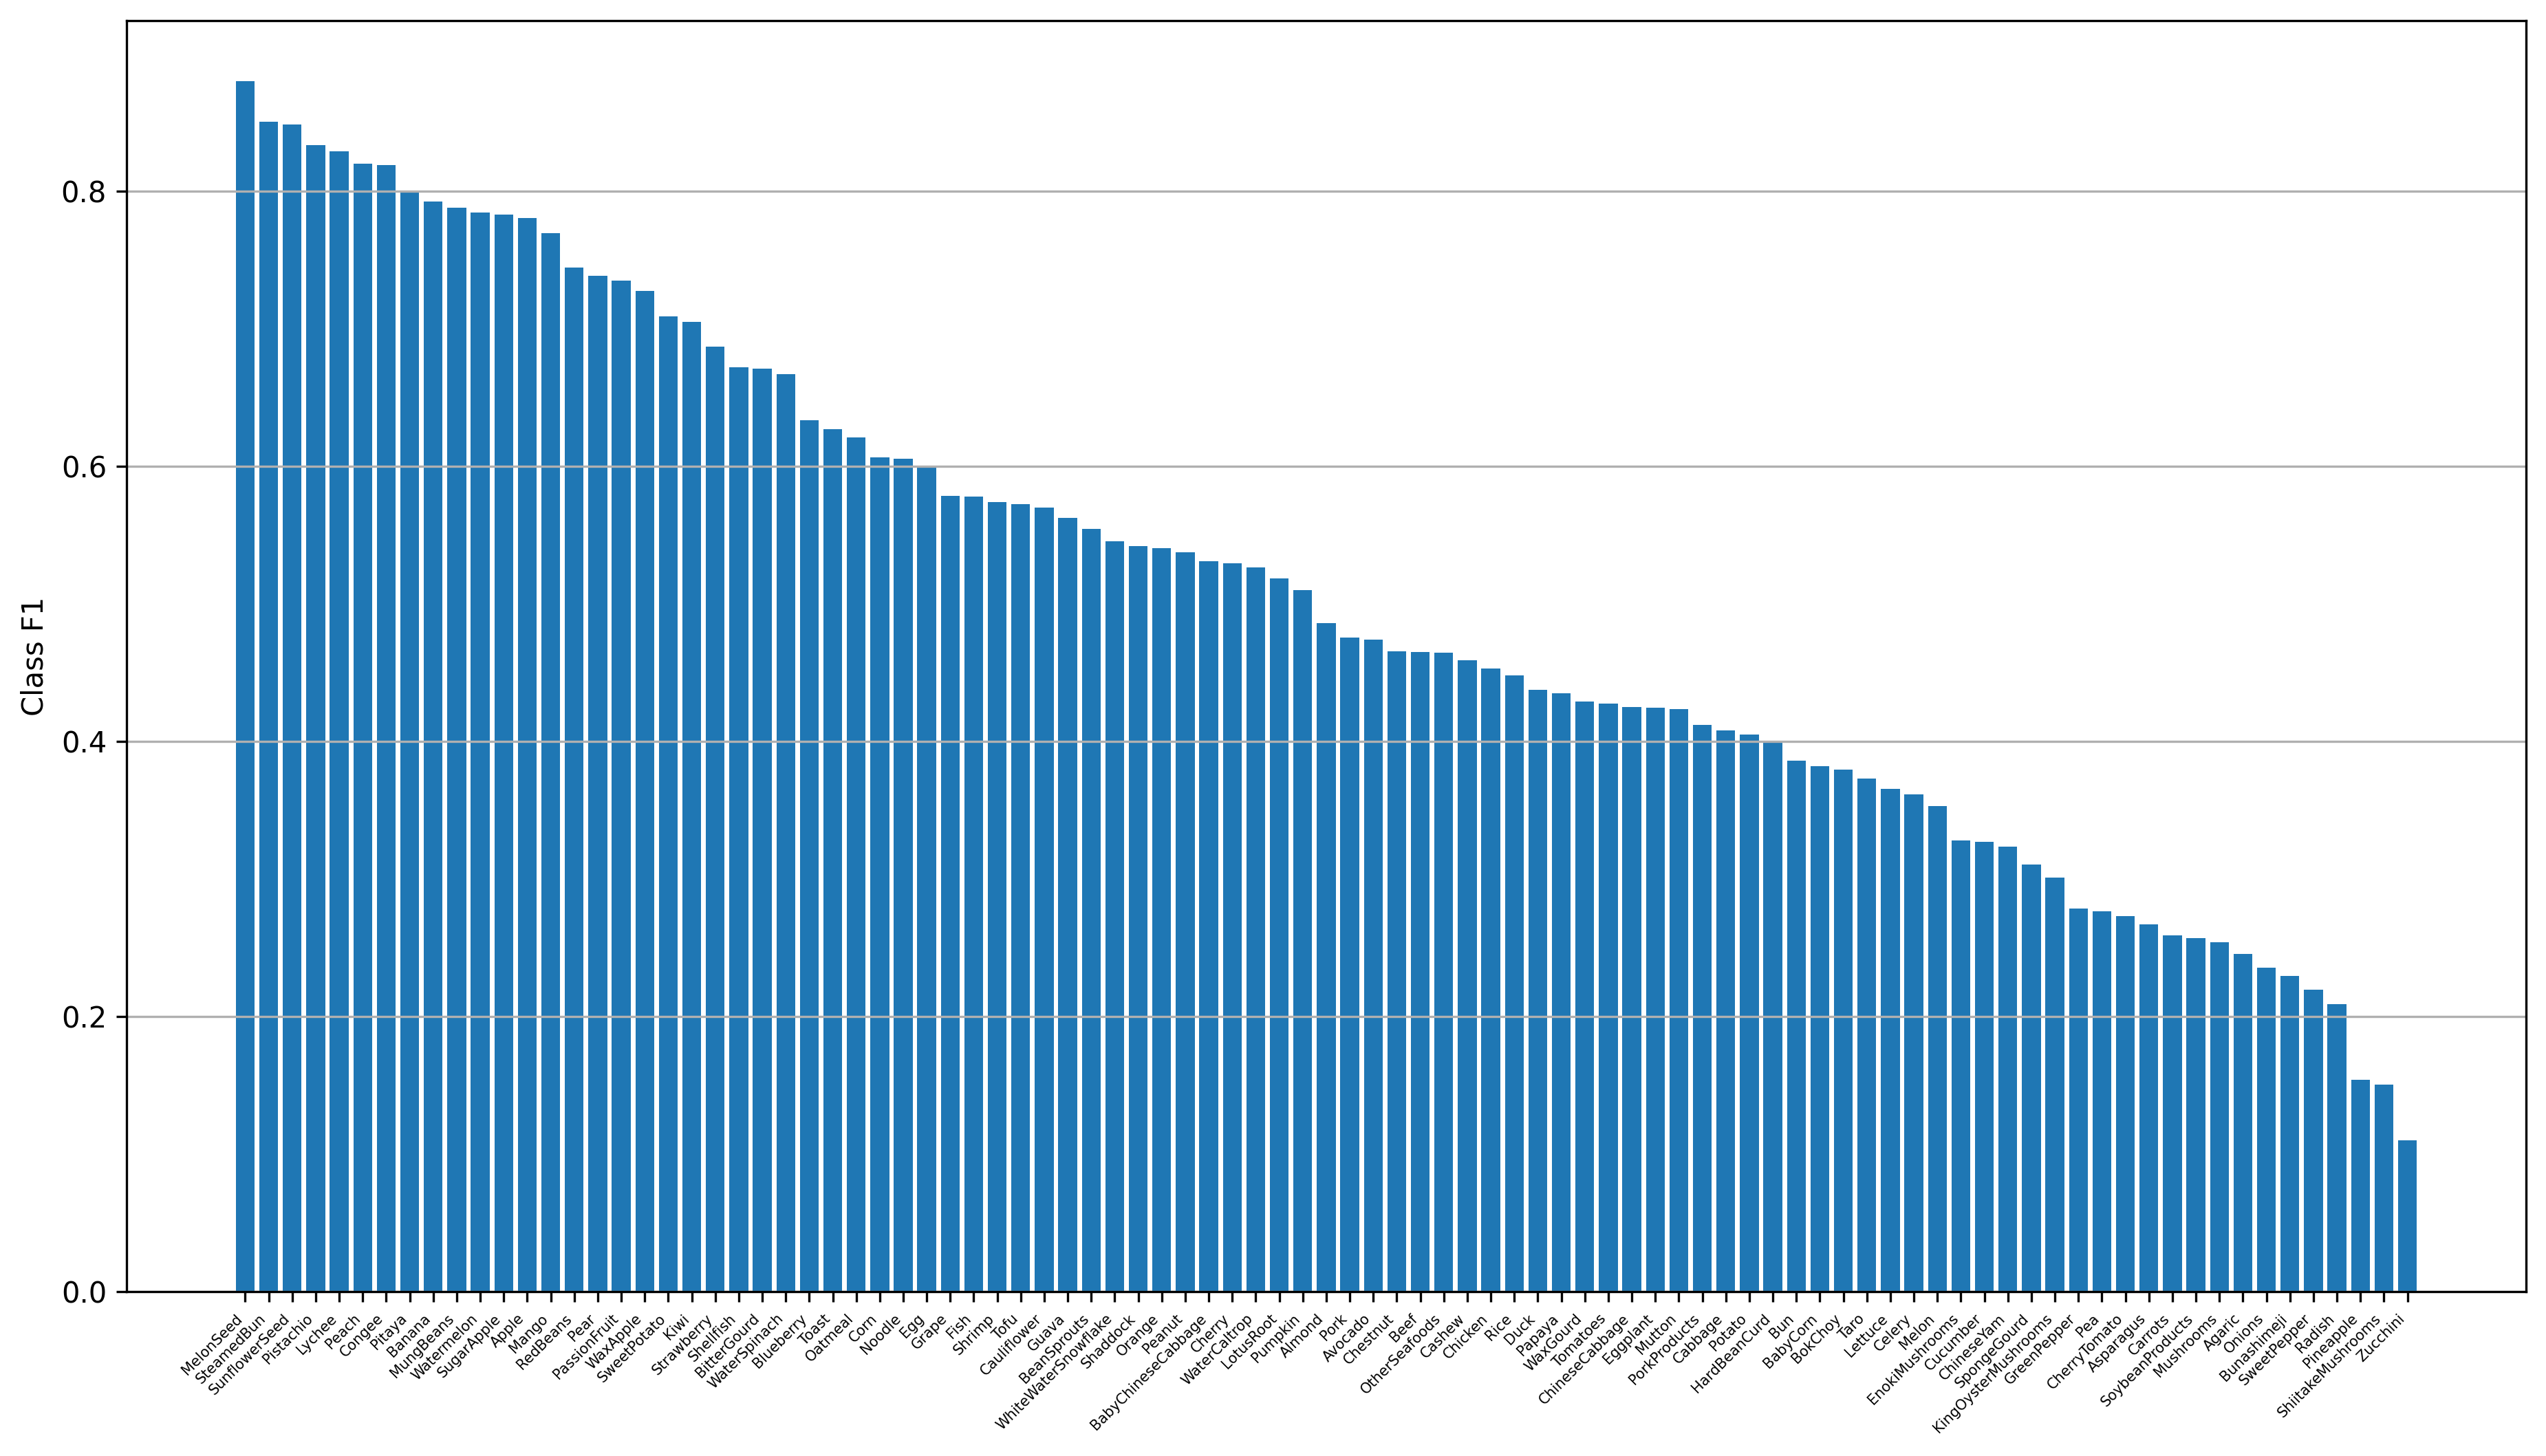

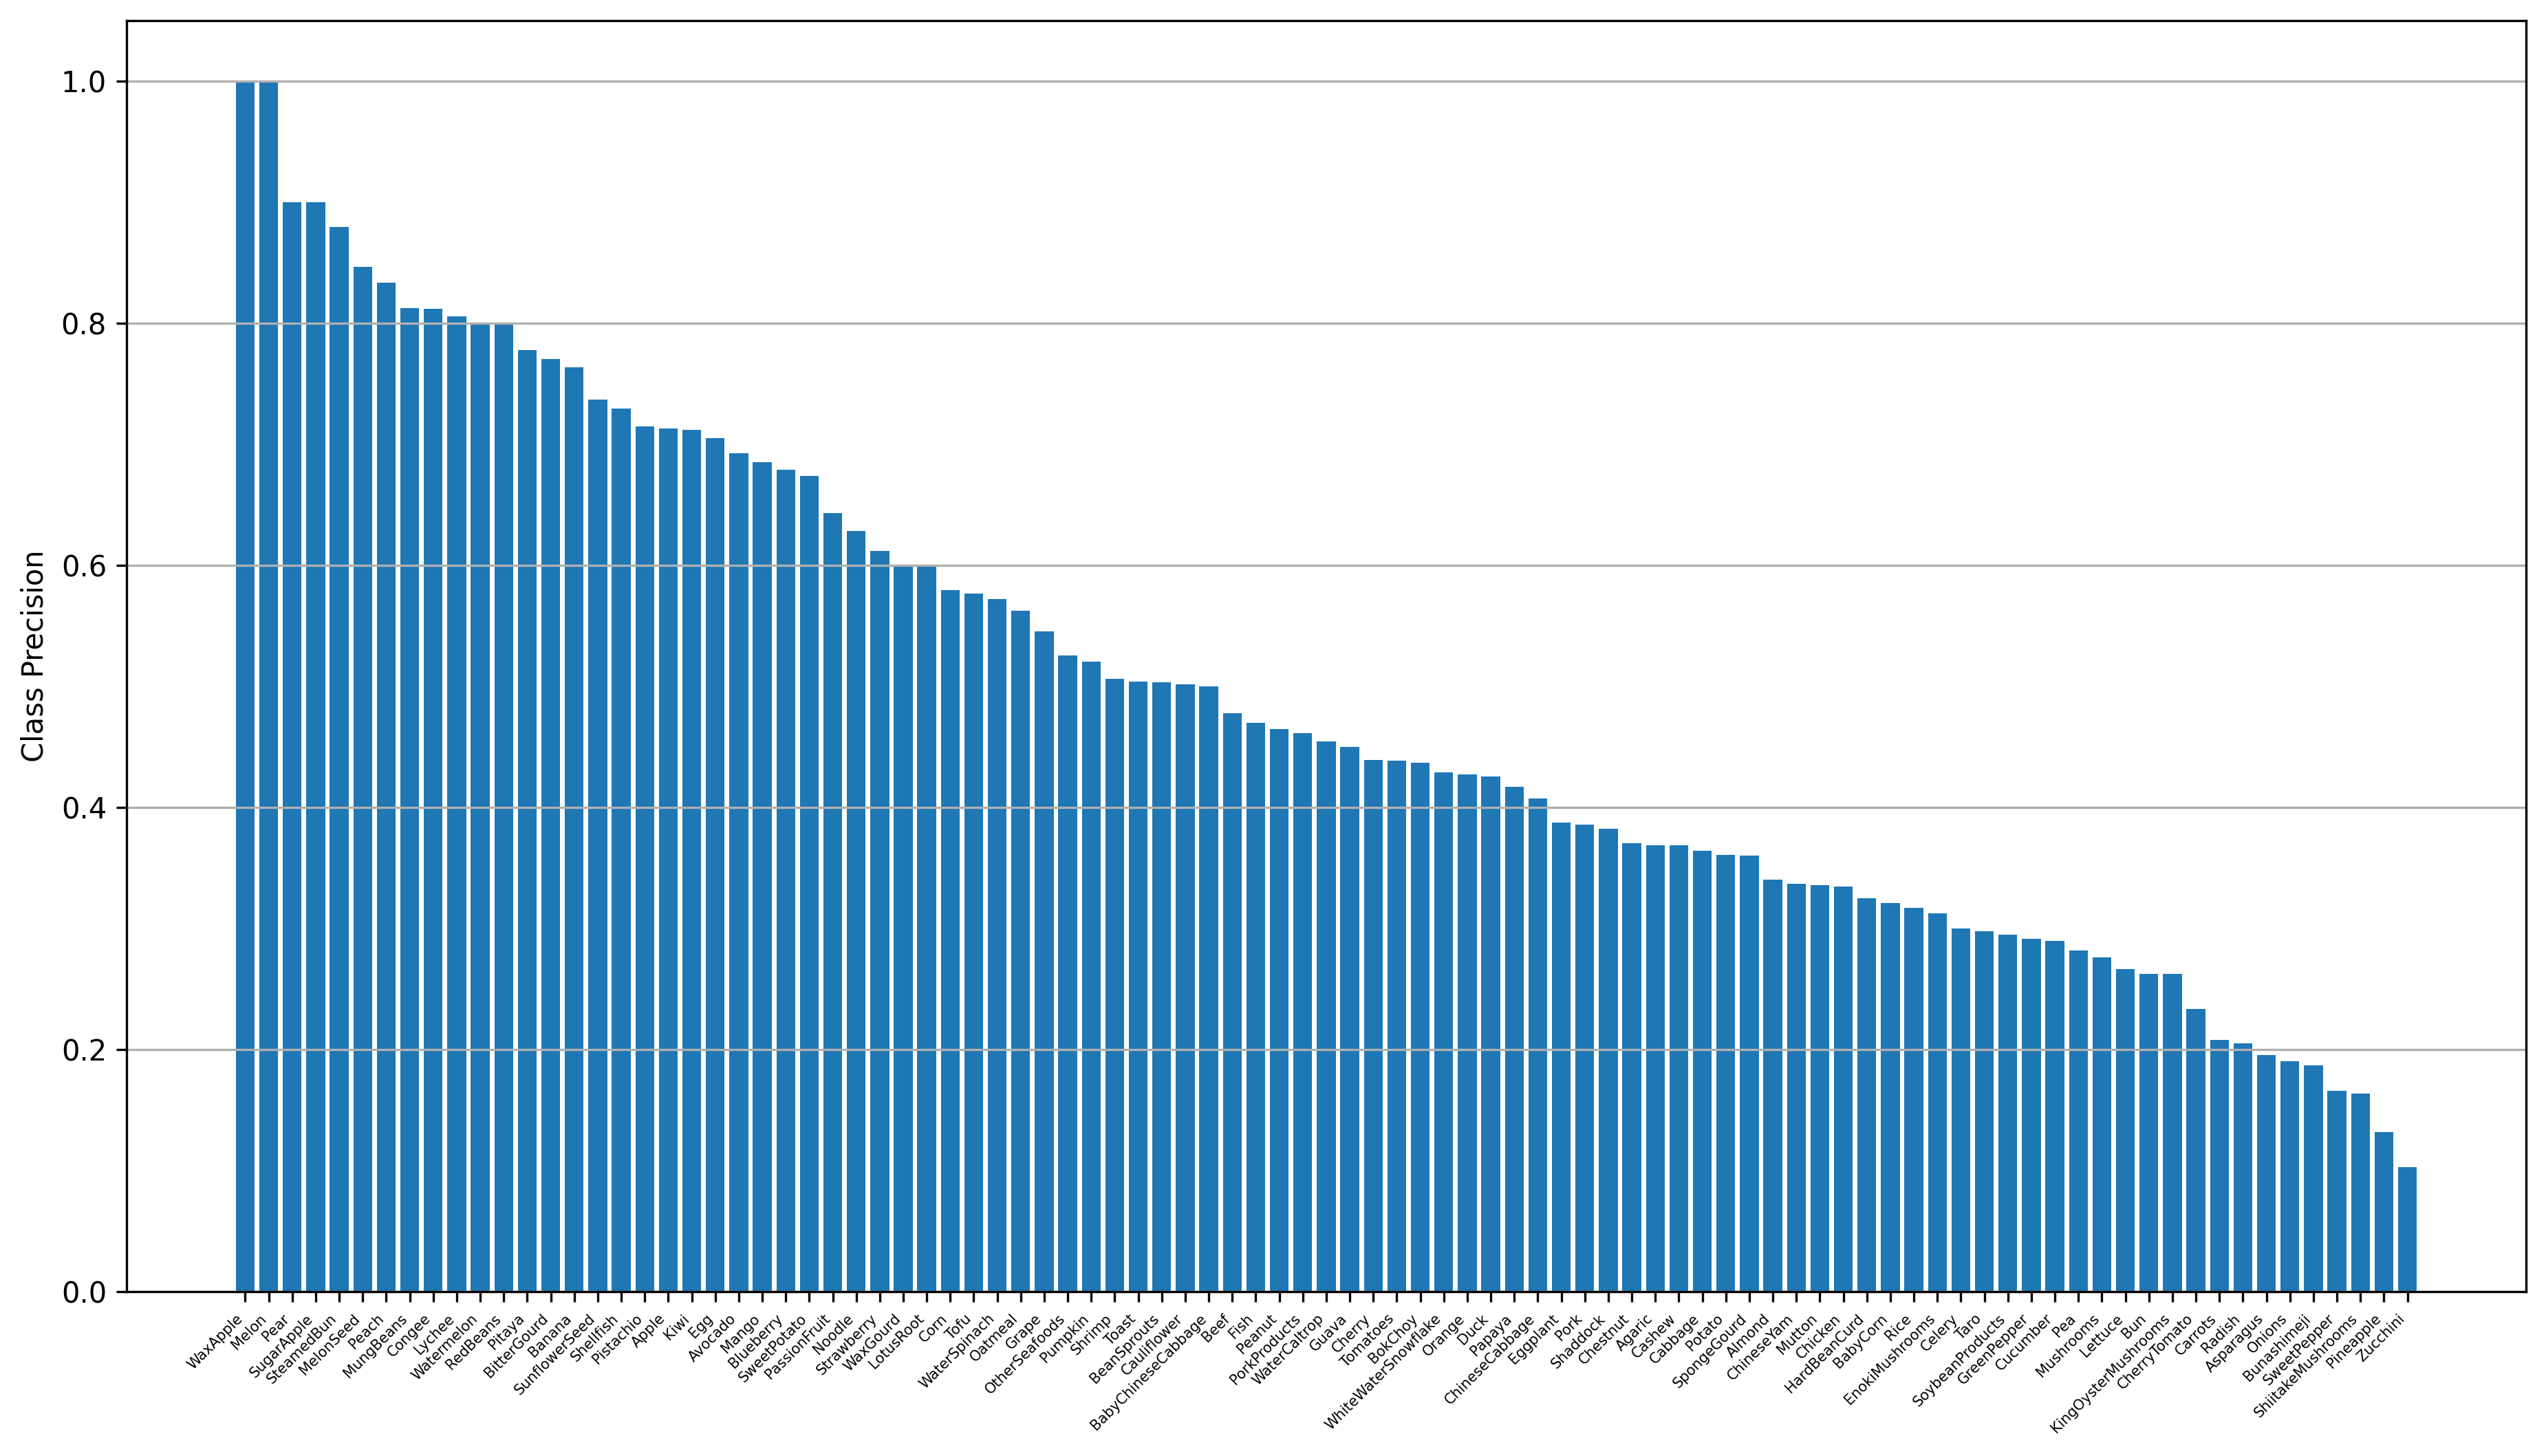

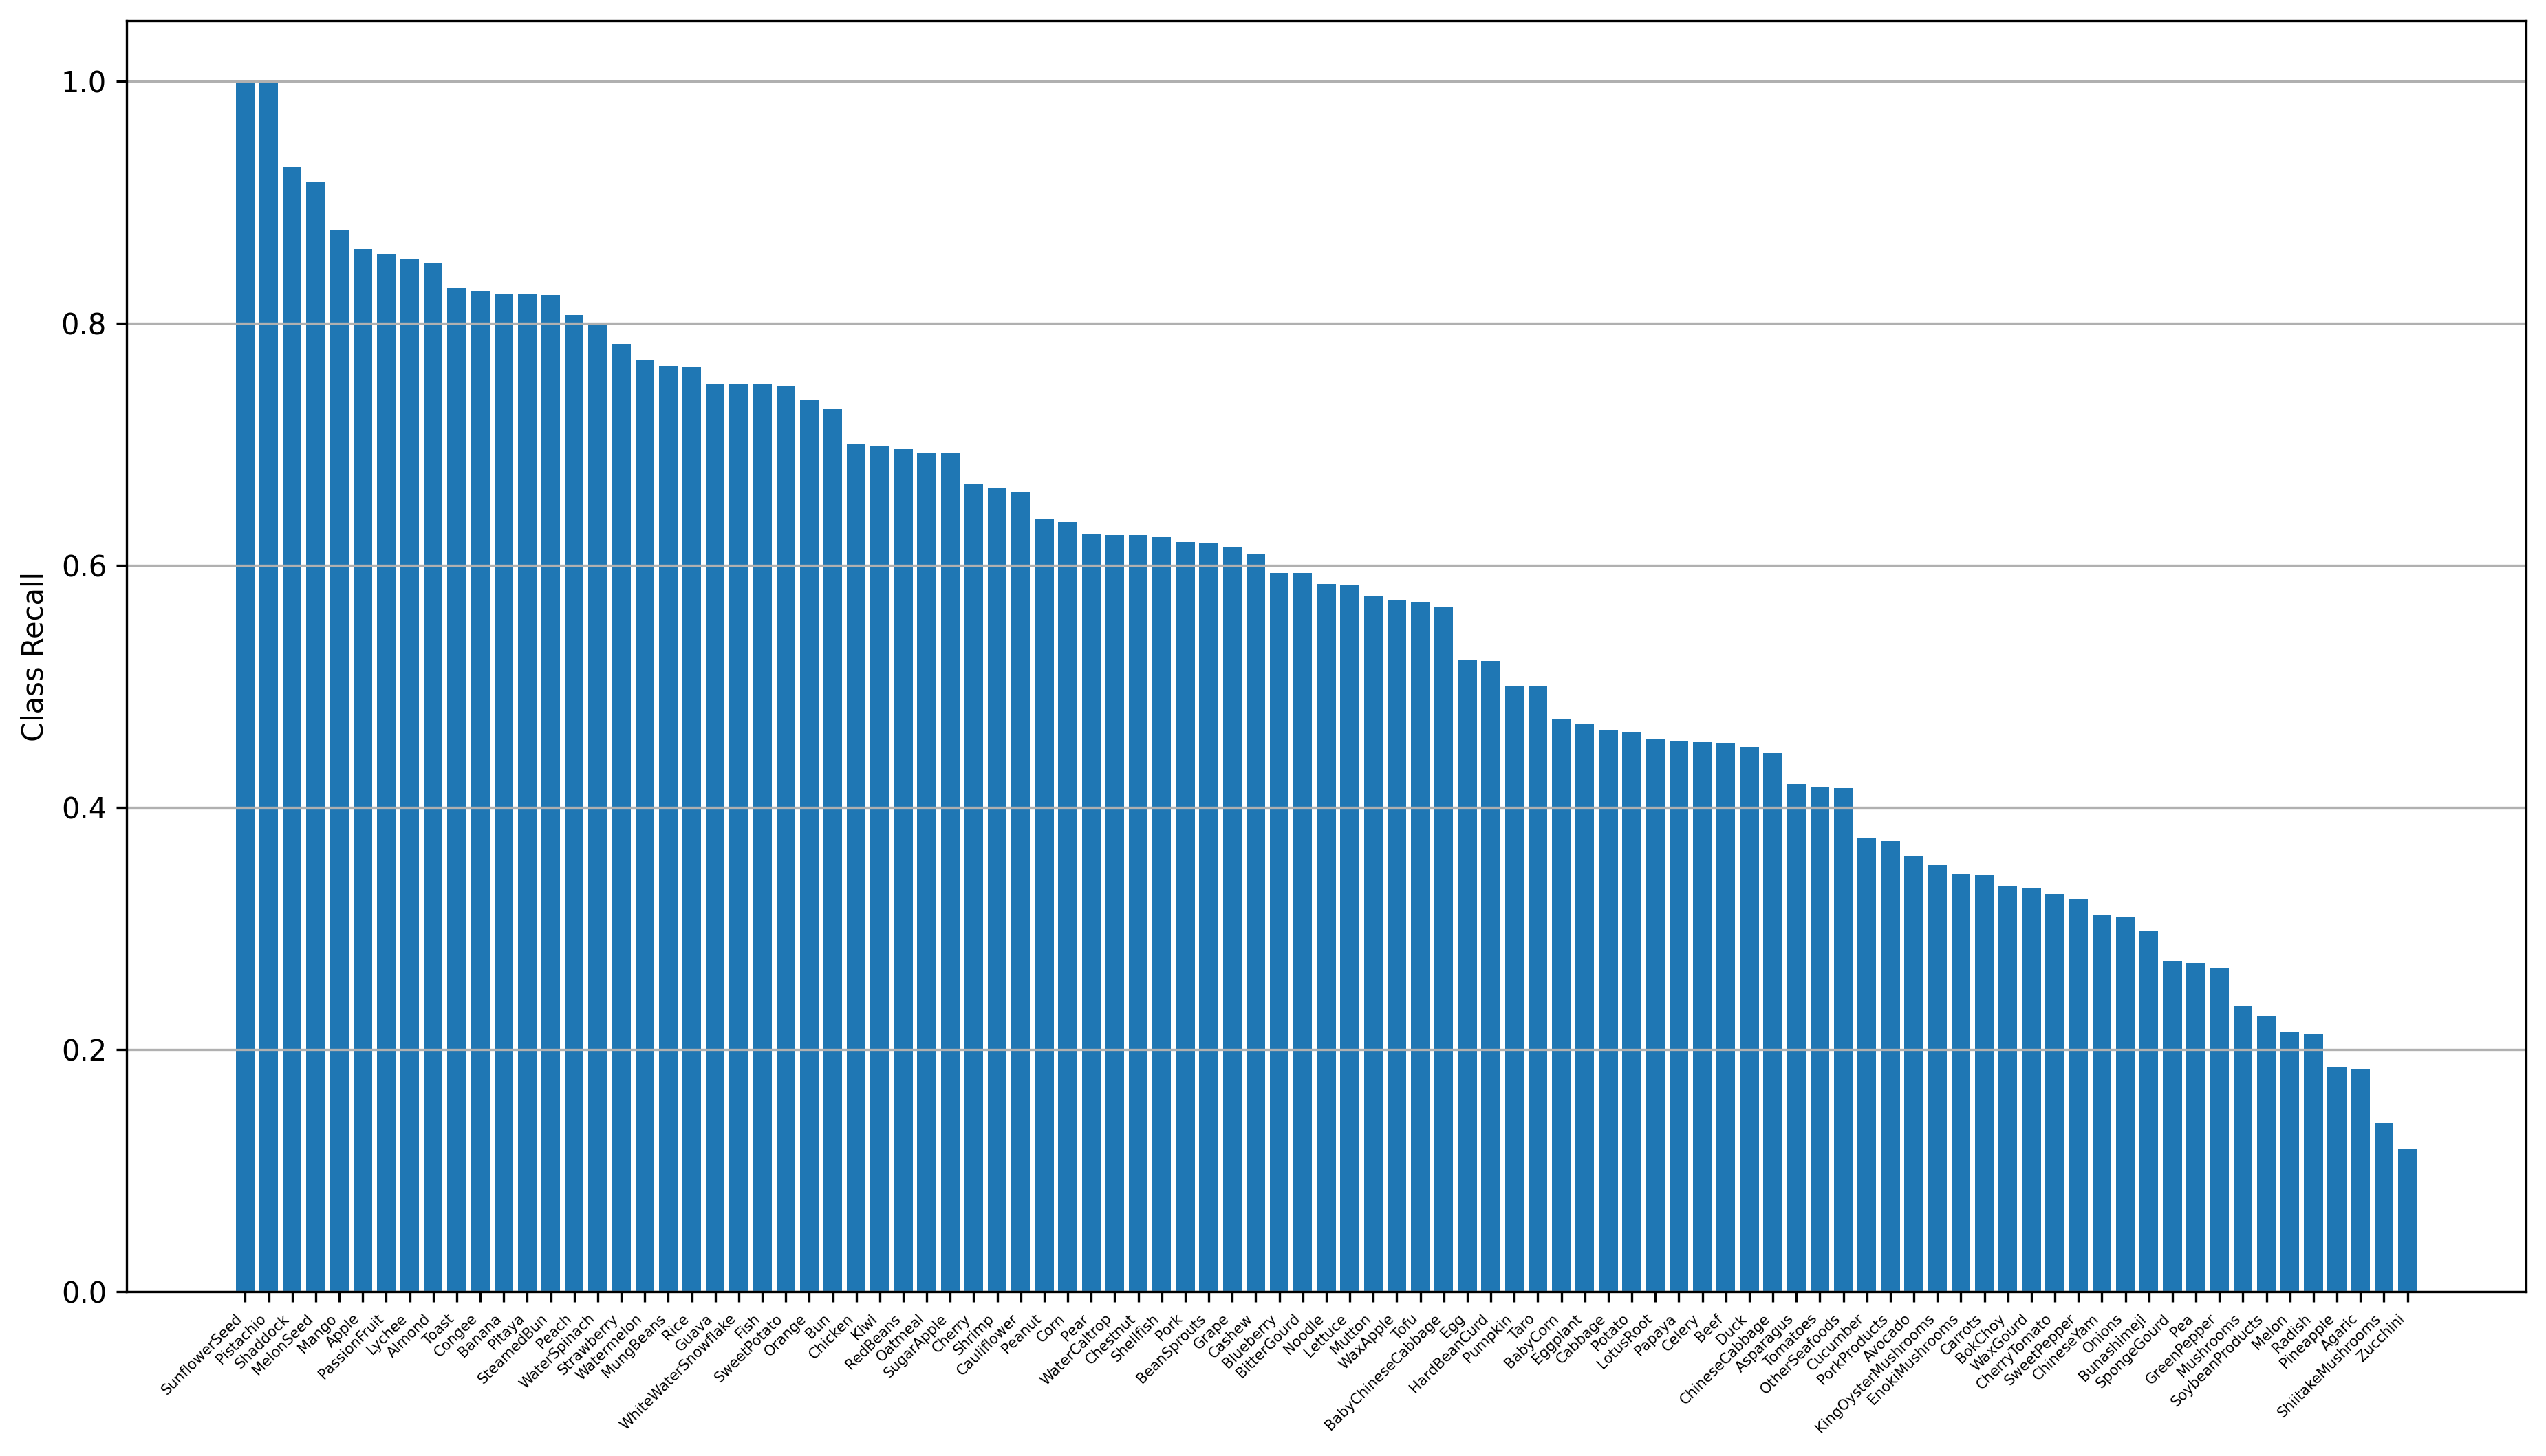

In [ ]:
# Sort accuracy
class_f1 = sort_class_acc(record_dict["valid_class_f1"].detach().cpu())
class_pr = sort_class_acc(record_dict["valid_class_precision"].detach().cpu())
class_re = sort_class_acc(record_dict["valid_class_recall"].detach().cpu())

fig1 = plot_acc(class_f1, ylabel="Class F1", show=True)
fig2 = plot_acc(class_pr, ylabel="Class Precision", show=True)
fig3 = plot_acc(class_re, ylabel="Class Recall", show=True)

fig1.savefig(f"{test_result_path}/aisinglefood/Class F1 100 epoch_15", bbox_inches=None)
fig2.savefig(f"{test_result_path}/aisinglefood/Class Precision 100 epoch_15", bbox_inches=None)
fig3.savefig(f"{test_result_path}/aisinglefood/Class Recall 100 epoch_15", bbox_inches=None)

plt.close(fig1)
plt.close(fig2)
plt.close(fig3)

In [20]:
list(filter(lambda x: "Soy" in x, class_f1.keys()))

['SoybeanProducts']

In [21]:
cls = "SoybeanProducts"
print(list(class_f1.keys()).index(cls))
print(f"F1: {class_f1[cls]}\nPrecision: {class_pr[cls]}\nRecall: {class_re[cls]}")


90
F1: 0.37383177876472473
Precision: 0.3030303120613098
Recall: 0.4878048896789551


In [ ]:
console.print(list(class_f1.items())[:10])
console.print(list(class_f1.items())[-10:])

[
    ('SunflowerSeed', 1.0),
    ('MelonSeed', 1.0),
    ('Pistachio', 0.93333334),
    ('Oatmeal', 0.9230769),
    ('Banana', 0.9142857),
    ('PassionFruit', 0.9142857),
    ('Grape', 0.9032258),
    ('Cherry', 0.9),
    ('Almond', 0.8947368),
    ('Bun', 0.875)
]

[
    ('HardBeanCurd', 0.39436617),
    ('Potato', 0.375),
    ('ShiitakeMushrooms', 0.35294116),
    ('EnokiMushrooms', 0.3333333),
    ('Lettuce', 0.30985916),
    ('GreenPepper', 0.29473683),
    ('Shrimp', 0.27906978),
    ('ChineseYam', 0.27586207),
    ('Mutton', 0.22222222),
    ('KingOysterMushrooms', 0.13333334)
]

In [53]:
print(f"{'Category':20} | {'F1':10} | {'Precision':10} | {'Recall':10}")
print(f"{'-':->20}-|-{'-':->10}-|-{'-':->10}-|-{'-':->10}")
for i in class_name :
    print(f"{i:20} | {class_f1[i]:.3f} ({list(class_f1.keys()).index(i)+1:2}) | " + 
        f"{class_pr[i]:.3f} ({list(class_pr.keys()).index(i)+1:2}) | {class_re[i]:.3f} ({list(class_re.keys()).index(i)+1:2})")

Category             | F1         | Precision  | Recall    
---------------------|------------|------------|-----------
Rice                 | 0.480 (71) | 0.750 (46) | 0.353 (83)
Congee               | 0.723 (32) | 0.607 (67) | 0.895 (11)
Noodle               | 0.743 (26) | 0.722 (52) | 0.765 (25)
SteamedBun           | 0.407 (81) | 0.289 (87) | 0.688 (37)
Oatmeal              | 0.923 ( 4) | 1.000 ( 1) | 0.857 (15)
Bun                  | 0.875 (10) | 0.933 (16) | 0.824 (19)
Toast                | 0.757 (22) | 0.875 (25) | 0.667 (41)
Pork                 | 0.440 (76) | 0.381 (80) | 0.521 (65)
PorkProducts         | 0.521 (65) | 0.407 (79) | 0.725 (30)
Chicken              | 0.692 (35) | 0.740 (49) | 0.649 (45)
Beef                 | 0.529 (64) | 0.426 (78) | 0.697 (36)
Mutton               | 0.222 (92) | 0.136 (93) | 0.611 (51)
Duck                 | 0.436 (77) | 0.364 (83) | 0.545 (59)
Apple                | 0.667 (38) | 0.889 (22) | 0.533 (60)
Banana               | 0.914 ( 5) | 0.94

#### json

In [22]:
# Save results
save_results(record_dict, f"{test_result_path}/aisinglefood/Test Results.json")

In [ ]:
# Load results
record_dict = load_results(f"{test_result_path}/aisinglefood/Test Results.json")
class_fp, class_fp_ratio, class_fp_name = get_class_fp(record_dict)

#### Excel

In [93]:
# Create workbook
wb = xlsx.Workbook()

In [94]:
# Class Precision, Recall, F1
write_class_acc(record_dict["valid_class_precision"], record_dict["valid_class_recall"], record_dict["valid_class_f1"], wb)

# Confusion matrix
write_conf_matrix(record_dict["conf_matrix"], wb)

# Class FP
write_misclassify_cls(class_fp_name,  class_fp,  class_fp_ratio,  wb)
write_misclassify_cls(class_fp_name2, class_fp2, class_fp_ratio2, wb, ws_name="FP to others")

In [ ]:
wb.save(f"{test_result_path}/singlefood/Test Result.xlsx")
wb.close()

## Testing on FoodSeg 103

In [ ]:
# Load dataset
dataloader = FoodDataset(foodseg_csv_path, transform=trfs, root=root_path)
dataloader = DataLoader(
    dataloader,
    batch_size=1,
    drop_last=True,
    shuffle=False,
    num_workers=cfg["WORKERS"],
)

# Read FoodSeg103 id mapping
with open("../Database/id_mapping.csv", "r") as file :
    reader = csv.reader(file)
    foodseg_ids = [int(i[1]) for i in reader]

In [ ]:
# Inference on images
try :
    record_dict_fs = evaluate_dataset_class_acc(
        model1,
        dataloader,
        cfg["MODEL"]["CATEGORY_NUM"],
        device
    )
except Exception :
    console.print_exception(show_locals=True)

In [25]:
record_dict_fs

{'valid_ham_loss': 0.026103977450673346,
 'valid_zero_acc': 0.0289644012944984,
 'valid_total_loss': 0.03549482509098877,
 'valid_microf1': 0.14234265685081482,
 'valid_macrof1': 0.053420186042785645,
 'valid_micro_acc': 0.9738960266113281,
 'valid_class_f1': tensor([0.0119, 0.0000, 0.3468, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1326,
         0.0000, 0.2428, 0.0927, 0.0000, 0.0000, 0.2486, 0.0000, 0.0149, 0.0000,
         0.1500, 0.0156, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0126, 0.2667,
         0.0000, 0.0000, 0.0455, 0.0000, 0.2066, 0.0000, 0.0000, 0.0000, 0.4348,
         0.0825, 0.0000, 0.0000, 0.1496, 0.0000, 0.0000, 0.0000, 0.0503, 0.0432,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0087, 0.0370, 0.2007, 0.0000,
         0.1213, 0.0000, 0.0000, 0.0000, 0.0000, 0.2061, 0.2298, 0.0354, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3319, 0.0000, 0.0000, 0.0000,
         0.1882, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0769, 0.0288,
         0.0

In [97]:
class_fp_fs,  class_fp_ratio_fs,  class_fp_name_fs  = get_class_fp(record_dict_fs["conf_matrix"])
class_fp2_fs, class_fp_ratio2_fs, class_fp_name2_fs = get_class_fp(torch.transpose(record_dict_fs["conf_matrix"], 0, 1))

#### Graph

In [14]:
# Sort accuracy
class_f1 = sort_class_acc(record_dict_fs["valid_class_f1"])
class_pr = sort_class_acc(record_dict_fs["valid_class_precision"])
class_re = sort_class_acc(record_dict_fs["valid_class_recall"])

fig1 = plot_acc(class_f1, ylabel="Class F1")
fig2 = plot_acc(class_pr, ylabel="Class Precision")
fig3 = plot_acc(class_re, ylabel="Class Recall")

fig1.savefig("./Results FoodSeg/Class F1", bbox_inches=None)
fig2.savefig("./Results FoodSeg/Class Precision", bbox_inches=None)
fig3.savefig("./Results FoodSeg/Class Recall", bbox_inches=None)

plt.close(fig1)
plt.close(fig2)
plt.close(fig3)

#### json

In [ ]:
# Save results
save_results(record_dict, f"{test_result_path}/foodseg/Test Results.json")

In [ ]:
# Load results
record_dict_fs = load_results(f"{test_result_path}/foodseg/Test Results.json", to_tensor=True)
class_fp_fs, class_fp_ratio_fs, class_fp_name_fs = get_class_fp(record_dict_fs["conf_matrix"])

#### Excel

In [110]:
# Create workbook
wb = xlsx.Workbook()

In [111]:
# Class Precision, Recall, F1
write_class_acc(
    record_dict_fs["valid_class_precision"], record_dict_fs["valid_class_recall"], record_dict_fs["valid_class_f1"],
    wb, include_class=foodseg_ids)

# Confusion matrix
write_conf_matrix(record_dict_fs["conf_matrix"], wb, include_class=foodseg_ids)

# Class FP
write_misclassify_cls(class_fp_name_fs,  class_fp_fs,  class_fp_ratio_fs,  wb, include_class=foodseg_ids)
write_misclassify_cls(class_fp_name2_fs, class_fp2_fs, class_fp_ratio2_fs, wb, ws_name="FP to others", include_class=foodseg_ids)

In [ ]:
wb.save(f"{test_result_path}/foodseg/Test Result.xlsx")
wb.close()

## Generate CAMs

In [25]:
try :
    generate_cam(model1, test_csv_path, cam_result_path)
except Exception :
    console.print_exception(show_locals=False)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 try :                                                                                        │
│ ❱ 2 │   generate_cam(model1, test_csv_path, cam_result_path)                                     │
│   3 except Exception :                                                                           │
│   4 │   console.print_exception(show_locals=False)                                               │
│   5                                                                                              │
│                                                                                                  │
│ /home/msoc/anaconda3/envs/food_torch/lib/python3.7/site-packages/torch/autograd/grad_mode.py:27  │
│ in decorate_context                                                                              │
│                                                                                                  │
│    24 │   │   @functools.wraps(func)                                                             │
│    25 │   │   def decorate_context(*args, **kwargs):                                             │
│    26 │   │   │   with self.clone():                                                             │
│ ❱  27 │   │   │   │   return func(*args, **kwargs)                                               │
│    28 │   │   return cast(F, decorate_context)                                                   │
│    29 │                                                                                          │
│    30 │   def _wrap_generator(self, func):                                                       │
│                                                                                                  │
│ in generate_cam:48                                                                               │
│                                                                                                  │
│    45 │   for img_path, labels in images :                                                       │
│    46 │   │                                                                                      │
│    47 │   │   # Load image                                                                       │
│ ❱  48 │   │   img_pil, img_tensor = load_image(img_path)                                         │
│    49 │   │                                                                                      │
│    50 │   │   # Inference                                                                        │
│    51 │   │   logits, preds, sorted_preds, pos_preds, cam = inference(model, img_tensor)         │
│                                                                                                  │
│ in load_image:7                                                                                  │
│                                                                                                  │
│     4 # Return PIL Image and image tensor (unsqueezed)                                           │
│     5 def load_image(img_path: str) -> "tuple[Image.Image, torch.Tensor]" :                      │
│     6 │   img_original = Image.open(img_path).convert("RGB")                                     │
│ ❱   7 │   image = trfs(img_original).to(device)                                                  │
│     8 │   images = torch.Tensor.unsqueeze(image, dim=0)                                          │
│     9 │   return img_original, images                                                            │
│    10                                                                                            │
│                                                            

## Test separated images

In [61]:
def is_image(path: str) :
    return path.lower().endswith((".jpg", ".jpeg", ".png", ".webp", ".avif"))

def get_folder_entries(path: str) :
    return [
        entry.path for entry in os.scandir(path) if is_image(entry.name)
    ]

def is_leaf_dir(path: str) :
    return os.path.isdir(path) and all(not entry.is_dir() for entry in os.scandir(path))


In [69]:
# Read csv files
image_labels: "dict[str, list[int]]" = {}
all_labels: "dict[str, list[int]]" = {}
with open(all_csv_path, "r") as file :
    reader = csv.reader(file)
    for img_path, *label_str in reader :
        labels = [0] * 93
        for l in label_str : labels[int(l)] = 1
        img_name = os.path.basename(img_path)
        image_labels[img_name] = labels
        all_labels[os.path.join(root_path, img_path)] = labels

valid_labels = {}
with open(val_csv_path, "r") as file :
    reader = csv.reader(file)
    for img_path, *label_str in reader :
        valid_labels[img_path] = [int(l) for l in label_str]

test_labels = {}
with open(test_csv_path, "r") as file :
    reader = csv.reader(file)
    for img_path, *label_str in reader :
        test_labels[img_path] = [int(l) for l in label_str]


In [ ]:
# Test all images of an category

@torch.no_grad()
def inference_cate_images(
    model: nn.Module,
    image_path: str,
    cate_name: str,
    gen_cam = False,
) -> dict :
    
    result = {}
    
    # Morphology
    for label_name in ("single_label", "multi_label") :
        label_dict = {}
        result[label_name] = label_dict
        
        # Color
        for color_entry in os.scandir(os.path.join(image_path, label_name)) :
            color_dict = {}
            label_dict[color_entry.name] = color_dict
            
            # Shape
            for shape_entry in os.scandir(color_entry.path) :
                shape_dict = {}
                color_dict[shape_entry.name] = shape_dict
                
                result_path = os.path.join(cam_result_path, cate_name, label_name, color_entry.name, shape_entry.name)
                pass_path = os.path.join(result_path, "pass")
                fail_path = os.path.join(result_path, "fail")
                os.makedirs(pass_path, exist_ok=True)
                os.makedirs(fail_path, exist_ok=True)
                
                # TP, TN, FN, FP of each class, for calculating Macro F1
                tp = torch.zeros(93, dtype=torch.int).to(device)
                fp = torch.zeros(93, dtype=torch.int).to(device)
                fn = torch.zeros(93, dtype=torch.int).to(device)
                tn = torch.zeros(93, dtype=torch.int).to(device)
                # For calculating zero accuracy
                err_data = 0
                data_count = 0
                
                # Images
                for img_entry in os.scandir(shape_entry.path) :
                    if not is_image(img_entry.path) : continue
                    
                    # Load image
                    img, img_tensor = load_image(img_entry.path)
                    
                    # Inference
                    logits, _, sorted_preds, pos_preds = inference(model, img_tensor)
                    preds = logits.round().int()
                    labels = torch.Tensor(image_labels[img_entry.name]).int().to(device)
                    
                    # Calculate accuracy
                    tp_fp_fn_tn = cal_tp_fp_fn_tn(preds, labels)
                    _, err = cal_error_nums(preds, labels)
                    tp += tp_fp_fn_tn[0]
                    fp += tp_fp_fn_tn[1]
                    fn += tp_fp_fn_tn[2]
                    tn += tp_fp_fn_tn[3]
                    err_data += err
                    data_count += 1
                    
                    if not gen_cam :
                        img.close()
                        continue
                    
                    # Generate CAM
                    basename = os.path.basename(img_entry.name).rsplit(".", maxsplit=1)[0]
                    cam = class_activation_map(model, img_tensor)
                    figure = merge_image_cam(img, cam, sorted_preds, pos_preds, class_id, show=False)
                    figure.savefig(
                        os.path.join(
                            pass_path if err == 0 else fail_path,
                            f"{basename}.png"
                        ),
                        pad_inches = 0,
                        bbox_inches = "tight"
                    )

                    plt.close(figure)
                    img.close()
                
                if data_count == 0 :
                    shape_dict["microf1"] = 0
                    shape_dict["zero_acc"] = 0
                    shape_dict["fail"] = 0
                    shape_dict["pass"] = 0
                else :
                    acc = cal_f1_score_acc(tp, fp, fn, tn)
                    acc.pop("macrof1")
                    acc.pop("micro_acc")
                    shape_dict.update(acc)
                    shape_dict["zero_acc"] = 1 - (err_data / data_count)
                    shape_dict["fail"] = err_data
                    shape_dict["pass"] = data_count - err_data
    
    return result

cate_path = "../test/Apple" # Path of test data
result = inference_cate_images(model1, cate_path, "Apple", gen_cam=True)


In [25]:
# Test all images

@torch.no_grad()
def evaluate_dataset_all( 
    model: nn.Module,
    class_alpha: torch.Tensor = None,
    gamma: float = 2,
) -> "dict[str, float]" :

    record_dict = {
        "valid_ham_loss"        : 0,
        "valid_zero_acc"        : 0,
        "valid_total_loss"      : 0,
        "valid_microf1"         : 0,
        "valid_macrof1"         : 0,
        "valid_micro_acc"       : 0,
        "valid_class_f1"        : None,
        "valid_class_precision" : None,
        "valid_class_recall"    : None,
        "tp"                    : None,
        "fp"                    : None,
        "fn"                    : None,
        "tn"                    : None,
        "conf_matrix"           : None,
    }

    # TP, TN, FN, FP of each class, for calculating Macro F1
    tp = torch.zeros(cfg["MODEL"]["CATEGORY_NUM"], dtype=torch.int).to(device)
    fp = torch.zeros(cfg["MODEL"]["CATEGORY_NUM"], dtype=torch.int).to(device)
    fn = torch.zeros(cfg["MODEL"]["CATEGORY_NUM"], dtype=torch.int).to(device)
    tn = torch.zeros(cfg["MODEL"]["CATEGORY_NUM"], dtype=torch.int).to(device)
    # For calculating Hamming acc and Zero acc
    err_label = 0
    err_data = 0
    label_count = 0
    data_count = 0

    model.eval() # Evaluation mode
    for idx, (img_path, label) in track(enumerate(all_labels.items()), total=len(all_labels)):
        img: torch.Tensor = load_image(img_path)[1]
        label: torch.Tensor = torch.Tensor(label).unsqueeze(0).to(device, dtype=torch.float32)
        
        out = model(img)["pred"]
        logits = torch.sigmoid(out)
        pred = torch.round(logits) # Threshold = 0.5
        
        # Loss
        loss = cal_class_focal_loss(out, label, class_alpha, gamma)

        # Metrics
        tp_fp_fn_tn = cal_tp_fp_fn_tn(pred, label)
        valid_err_cor = cal_error_nums(pred, label)
        label_count += label.numel()
        data_count += len(label)

        record_dict["valid_total_loss"] += loss.item()
        tp += tp_fp_fn_tn[0]
        fp += tp_fp_fn_tn[1]
        fn += tp_fp_fn_tn[2]
        tn += tp_fp_fn_tn[3]
        err_label += valid_err_cor[0]
        err_data  += valid_err_cor[1]
        
    # Record loss and metrics
    valid_metrics_results = cal_f1_score_acc(tp, fp, fn, tn, class_acc=True)
    #? Use `float` to ensure all values are not Tensor
    record_dict["valid_microf1"]          = float(valid_metrics_results["microf1"])
    record_dict["valid_macrof1"]          = float(valid_metrics_results["macrof1"])
    record_dict["valid_micro_acc"]        = float(valid_metrics_results["micro_acc"])
    record_dict["valid_ham_loss"]         = float(err_label / label_count)
    record_dict["valid_zero_acc"]         = float(1 - err_data / data_count)
    record_dict["valid_total_loss"]      /= len(all_labels)
    record_dict["valid_class_f1"]         = valid_metrics_results["class_f1"]
    record_dict["valid_class_precision"]  = valid_metrics_results["class_precision"]
    record_dict["valid_class_recall"]     = valid_metrics_results["class_recall"]
    record_dict["tp"] = tp.cpu()
    record_dict["fp"] = fp.cpu()
    record_dict["fn"] = fn.cpu()
    record_dict["tn"] = tn.cpu()

    return record_dict

record_dict_all = evaluate_dataset_all(model1)

Output()

/home/msoc/anaconda3/envs/food_torch/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with
Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "

In [26]:
record_dict_all

{'valid_ham_loss': 0.007604984688622114,
 'valid_zero_acc': 0.5733843833391346,
 'valid_total_loss': 0.005070182772574038,
 'valid_microf1': 0.7146022915840149,
 'valid_macrof1': 0.7405447959899902,
 'valid_micro_acc': 0.9923949837684631,
 'valid_class_f1': tensor([0.7913, 0.9077, 0.7675, 0.9229, 0.9091, 0.6723, 0.8075, 0.7056, 0.6304,
         0.5734, 0.6932, 0.5563, 0.5938, 0.9154, 0.9084, 0.9017, 0.4814, 0.8790,
         0.8885, 0.8522, 0.8903, 0.4121, 0.8166, 0.8918, 0.8910, 0.8596, 0.8652,
         0.9277, 0.8793, 0.8201, 0.9520, 0.8260, 0.9638, 0.9430, 0.9534, 0.6408,
         0.7913, 0.8213, 0.6931, 0.6847, 0.7223, 0.5081, 0.9163, 0.6428, 0.4168,
         0.6974, 0.4366, 0.6967, 0.7362, 0.5937, 0.6066, 0.6553, 0.5521, 0.7193,
         0.7645, 0.7290, 0.7670, 0.7605, 0.4918, 0.7593, 0.8519, 0.6918, 0.8441,
         0.7256, 0.7251, 0.6998, 0.7761, 0.8599, 0.6228, 0.9639, 0.8758, 0.8250,
         0.5828, 0.7631, 0.5954, 0.9295, 0.8899, 0.9669, 0.9697, 0.6972, 0.1466,
         0.602

In [71]:
# Test validation images

@torch.no_grad()
def evaluate_dataset_valid_test( 
    model: nn.Module,
    class_alpha: torch.Tensor = None,
    gamma: float = 2,
) -> "dict[str, float]" :

    record_dict = {
        "valid_ham_loss"        : 0,
        "valid_zero_acc"        : 0,
        "valid_total_loss"      : 0,
        "valid_microf1"         : 0,
        "valid_macrof1"         : 0,
        "valid_micro_acc"       : 0,
        "valid_class_f1"        : None,
        "valid_class_precision" : None,
        "valid_class_recall"    : None,
        "tp"                    : None,
        "fp"                    : None,
        "fn"                    : None,
        "tn"                    : None,
        "conf_matrix"           : None,
    }

    # TP, TN, FN, FP of each class, for calculating Macro F1
    tp = torch.zeros(cfg["MODEL"]["CATEGORY_NUM"], dtype=torch.int).to(device)
    fp = torch.zeros(cfg["MODEL"]["CATEGORY_NUM"], dtype=torch.int).to(device)
    fn = torch.zeros(cfg["MODEL"]["CATEGORY_NUM"], dtype=torch.int).to(device)
    tn = torch.zeros(cfg["MODEL"]["CATEGORY_NUM"], dtype=torch.int).to(device)
    # For calculating Hamming acc and Zero acc
    err_label = 0
    err_data = 0
    label_count = 0
    data_count = 0
    # Failed data
    failed = []

    valid_labels.update(test_labels)

    model.eval() # Evaluation mode
    for idx, (img_path, label) in track(enumerate(valid_labels.items()), total=len(valid_labels)):
        img: torch.Tensor = load_image(os.path.join(root_path, img_path))[1]
        label: torch.Tensor = torch.Tensor(label).unsqueeze(0).to(device, dtype=torch.float32)
        
        out = model(img)["pred"]
        logits = torch.sigmoid(out)
        pred = torch.round(logits) # Threshold = 0.5
        
        # Loss
        loss = cal_class_focal_loss(out, label, class_alpha, gamma)

        # Metrics
        tp_fp_fn_tn = cal_tp_fp_fn_tn(pred, label)
        valid_err_cor = cal_error_nums(pred, label)
        label_count += label.numel()
        data_count += len(label)

        record_dict["valid_total_loss"] += loss.item()
        tp += tp_fp_fn_tn[0]
        fp += tp_fp_fn_tn[1]
        fn += tp_fp_fn_tn[2]
        tn += tp_fp_fn_tn[3]
        err_label += valid_err_cor[0]
        err_data  += valid_err_cor[1]
        
        if valid_err_cor[1] != 0 : failed.append(img_path)
        
    # Record loss and metrics
    valid_metrics_results = cal_f1_score_acc(tp, fp, fn, tn, class_acc=True)
    #? Use `float` to ensure all values are not Tensor
    record_dict["valid_microf1"]          = float(valid_metrics_results["microf1"])
    record_dict["valid_macrof1"]          = float(valid_metrics_results["macrof1"])
    record_dict["valid_micro_acc"]        = float(valid_metrics_results["micro_acc"])
    record_dict["valid_ham_loss"]         = float(err_label / label_count)
    record_dict["valid_zero_acc"]         = float(1 - err_data / data_count)
    record_dict["valid_total_loss"]      /= len(valid_labels)
    record_dict["valid_class_f1"]         = valid_metrics_results["class_f1"]
    record_dict["valid_class_precision"]  = valid_metrics_results["class_precision"]
    record_dict["valid_class_recall"]     = valid_metrics_results["class_recall"]
    record_dict["tp"] = tp.cpu()
    record_dict["fp"] = fp.cpu()
    record_dict["fn"] = fn.cpu()
    record_dict["tn"] = tn.cpu()

    return record_dict, failed

record_dict_valid, failed_data = evaluate_dataset_valid_test(model1)

Output()

/home/msoc/anaconda3/envs/food_torch/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with
Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "

In [65]:
len(failed_data)

10044

In [66]:
record_dict_valid

{'valid_ham_loss': 0.012140323920636764,
 'valid_zero_acc': 0.4436998061478815,
 'valid_total_loss': 0.007580393816641054,
 'valid_microf1': 0.6337124705314636,
 'valid_macrof1': 0.6423293948173523,
 'valid_micro_acc': 0.9878596663475037,
 'valid_class_f1': tensor([0.7171, 0.8686, 0.7492, 0.7855, 0.8108, 0.5344, 0.7093, 0.6639, 0.4959,
         0.6027, 0.5094, 0.4424, 0.4971, 0.7532, 0.8785, 0.8095, 0.4045, 0.8163,
         0.8387, 0.7476, 0.8182, 0.4783, 0.6047, 0.7826, 0.8571, 0.7143, 0.8319,
         0.6977, 0.6486, 0.6173, 0.8261, 0.7218, 0.8471, 0.8642, 0.6538, 0.6444,
         0.6818, 0.6928, 0.5869, 0.5655, 0.6654, 0.5192, 0.7037, 0.5723, 0.4374,
         0.5533, 0.3147, 0.6344, 0.4507, 0.5538, 0.5433, 0.5806, 0.4728, 0.5714,
         0.6437, 0.6416, 0.5581, 0.7312, 0.4222, 0.8574, 0.7916, 0.5142, 0.6667,
         0.4898, 0.3654, 0.4898, 0.7041, 0.7857, 0.6264, 0.8889, 0.5490, 0.7568,
         0.4531, 0.7277, 0.7586, 0.9730, 0.6667, 0.8500, 0.9032, 0.4575, 0.4275,
         0.466

In [67]:
with open("failed_0503.txt", "w") as file :
    file.writelines(f + "\n" for f in failed_data)